In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load your time series dataset
data = pd.read_csv('/kaggle/input/solarwind/solarwind.csv', index_col='datetime', parse_dates=['datetime'])

solar_features = ['global_horizontal_irradiance', 'direct_normal_irradiance', 'diffuse_horizontal_irradiance',
                  'solar_altitude_angle', 'solar_azimuth_angle', 'solar_incident_angle', 'horizon_elevation_angle',
                  'tracker_roll_angle', 'adjusted_ghi', 'poa_direct_irradiance', 'poa_diffuse_irradiance',
                  'poa_reflected_irradiance', 'shaded_direct_irradiance', 'shaded_diffuse_irradiance',
                  'shaded_reflected_irradiance', 'effective_direct_irradiance', 'effective_diffuse_irradiance',
                  'effective_reflected_irradiance', 'soiled_irradiance', 'total_irradiance', 'nameplate_power',
                  'avg_cell_temp', 'module_irradiance_derated_power', 'module_mpp_power', 'module_power',
                  'optimizer_input_power', 'optimizer_output_power', 'optimal_dc_power', 'optimal_dc_voltage',
                  'inverter_overpower_loss', 'inverter_underpower_loss', 'inverter_overvoltage_loss',
                  'inverter_undervoltage_loss', 'actual_dc_power', 'actual_dc_voltage', 'ac_power', 'grid_power']
wind_features = ['pressure', 'temperature_2m', 'wind_speed_10m', 'wind_speed_50m', 'wind_speed_150m',
                 'temperature_122m', 'roughness_length', 'dry_bulb_temperature', 'windspeed']
target_feature = 'power_output'


# Feature Engineering (create daylight feature and extract time-related features)
data['is_daylight'] = np.where(data['solar_incident_angle'] != 0, True, False)
data['hour'] = data.index.hour
data['day'] = data.index.dayofyear
# data['timestamp'] = data.index


In [41]:
# Selecting all features for feature engineering and importance calculations
input_features = ['is_daylight', 'hour', 'day'] + solar_features + wind_features
input_features.sort()
target_feature = 'power_output'

# Prepare input (X) and target (y)
X = data[input_features]
y = data[target_feature]

# Split data into training, validation, and prediction sets
X_train, X_temp, y_train, y_temp = train_test_split(data[input_features], data[target_feature], test_size=0.3, shuffle=False)
X_val, X_pred, y_val, y_pred = train_test_split(X_temp, y_temp, test_size=0.33, shuffle=False)

In [26]:
# X_train.info()

# print(X_train.sample(10))

# X_train.describe()

In [42]:
# Scaling and resampling for RF Regression for feature impotrance
# Prepare input (X) and target (y)
X = data[input_features]
y = data[target_feature]

# Resample data to hourly frequency
X_resampled = X.resample('H').mean()
y_resampled = y.resample('H').mean()

# Prepare input (X) and target (y)
X = X_resampled
y = y_resampled

# Split data into training, validation, and prediction sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_pred, y_val, y_pred = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)

# Normalize the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape y_train
y_test_scaled = scaler_y.fit_transform(y_val.values.reshape(-1, 1))  

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                            Feature  Correlation
46                  wind_speed_150m     0.956976
45                   wind_speed_10m     0.955029
47                   wind_speed_50m     0.893813
13                       grid_power     0.149260
0                          ac_power     0.149260
1                   actual_dc_power     0.149020
22                 module_mpp_power     0.148812
25                 optimal_dc_power     0.148490
23                     module_power     0.148373
26               optimal_dc_voltage     0.141897
37                soiled_irradiance     0.141211
43                 total_irradiance     0.141209
24                  nameplate_power     0.141209
21  module_irradiance_derated_power     0.140653
2                 actual_dc_voltage     0.140257
10      effective_direct_irradiance     0.129741
30            poa_direct_irradiance     0.128789
35         shaded_direct_irradiance     0.128558
38             solar_altitude_angle     0.114281
48                  

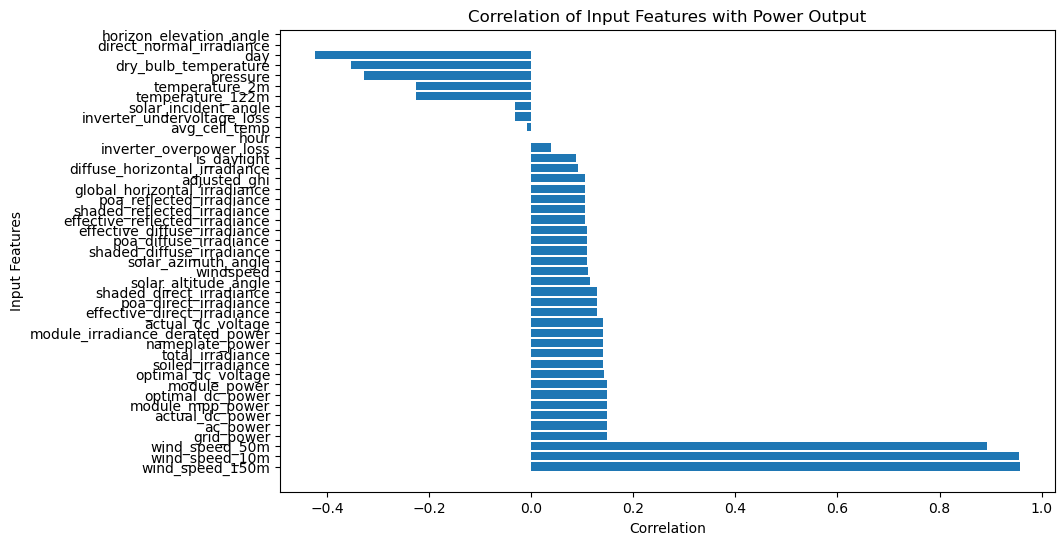

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# input_features = data.columns
# Calculate correlation
correlation = pd.DataFrame({'Feature': input_features})
correlation['Correlation'] = [np.corrcoef(X_train_scaled[:, i], y_train_scaled.flatten())[0, 1] for i in range(X_train_scaled.shape[1])]
correlation = correlation.sort_values(by='Correlation', ascending=False)

print(correlation)

# Plot correlation values
plt.figure(figsize=(10, 6))
plt.barh(correlation['Feature'], correlation['Correlation'])
plt.xlabel("Correlation")
plt.ylabel("Input Features")
plt.title("Correlation of Input Features with Power Output")
plt.show()


Feature Importance Ranking:
1. wind_speed_150m: 0.9998851312109501
2. wind_speed_10m: 5.7559287155522135e-05
3. pressure: 1.2458289556529478e-05
4. day: 6.896467156217322e-06
5. dry_bulb_temperature: 6.621096030205217e-06
6. wind_speed_50m: 4.971859811841794e-06
7. actual_dc_voltage: 4.530643397715649e-06
8. optimal_dc_voltage: 4.096206540421924e-06
9. temperature_122m: 3.0558449200811605e-06
10. solar_altitude_angle: 2.899289422260426e-06
11. temperature_2m: 2.8868071702917745e-06
12. effective_direct_irradiance: 2.0160436350010057e-06
13. module_irradiance_derated_power: 8.468942323379432e-07
14. soiled_irradiance: 7.748268776007923e-07
15. total_irradiance: 7.069323642609599e-07
16. actual_dc_power: 6.975084167682286e-07
17. module_power: 6.95012883433096e-07
18. nameplate_power: 6.837199210558874e-07
19. module_mpp_power: 6.436730455228959e-07
20. grid_power: 6.257036896135515e-07
21. ac_power: 6.059894205804284e-07
22. optimal_dc_power: 5.966934026592315e-07


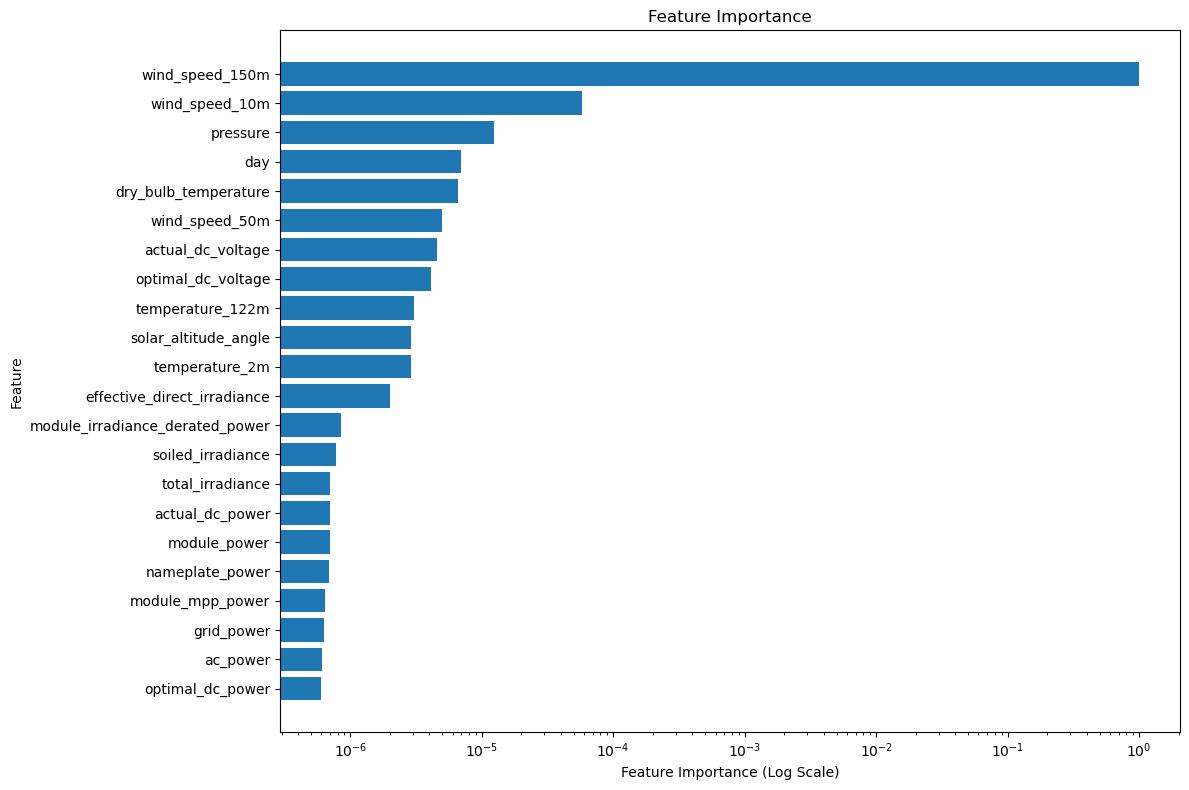

In [300]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the feature names in the original order
feature_names = input_features

# Print the feature importance ranking
print("Feature Importance Ranking:")
for i, idx in enumerate(sorted_indices):
    print(f"{i+1}. {feature_names[idx]}: {feature_importances[idx]}")

import matplotlib.pyplot as plt

# Plot the feature importances on a log scale
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance (Log Scale)')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.xscale('log')  # Use log scale for x-axis
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.tight_layout()
plt.show()

wind_speed_150m                    0.957553
wind_speed_10m                     0.956770
wind_speed_50m                     0.889524
pressure                           0.269868
dry_bulb_temperature               0.264689
day                                0.257511
grid_power                         0.166979
ac_power                           0.166979
actual_dc_power                    0.166772
optimal_dc_voltage                 0.166539
module_mpp_power                   0.166315
optimal_dc_power                   0.166058
module_power                       0.165922
soiled_irradiance                  0.159678
total_irradiance                   0.159675
nameplate_power                    0.159675
module_irradiance_derated_power    0.158844
actual_dc_voltage                  0.156539
solar_altitude_angle               0.140691
effective_direct_irradiance        0.139779
shaded_diffuse_irradiance          0.139448
poa_diffuse_irradiance             0.139448
effective_diffuse_irradiance    

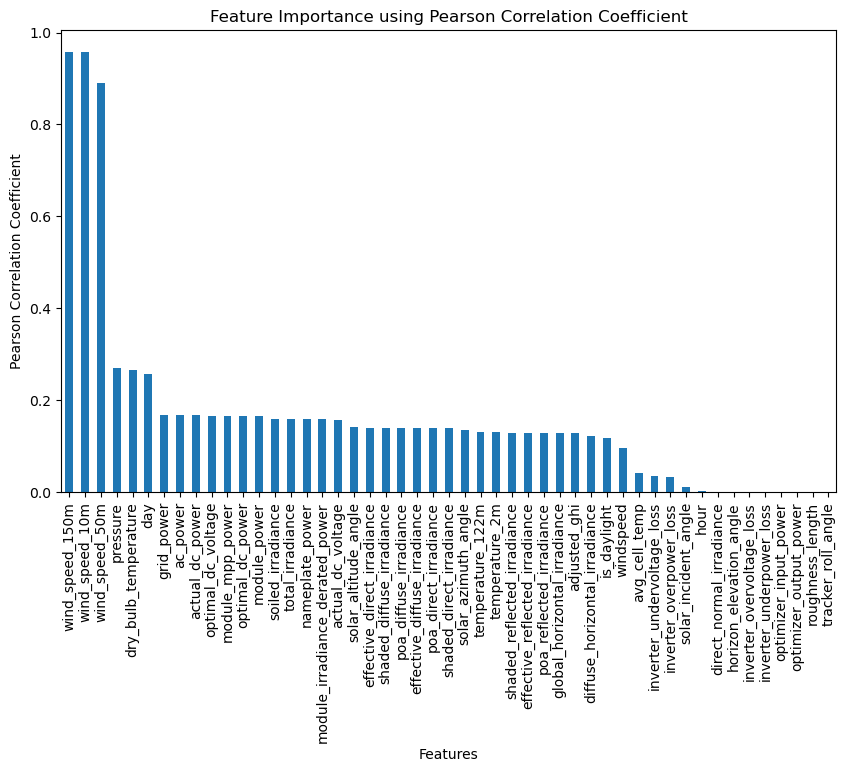

In [28]:

# Calculate Pearson correlation coefficients
correlation_coeffs = data[input_features + [target_feature]].corr()[target_feature]

# Exclude the target variable itself
correlation_coeffs = correlation_coeffs.drop(target_feature)

# Sort the coefficients in descending order of absolute values
sorted_coeffs = correlation_coeffs.abs().sort_values(ascending=False)

print(sorted_coeffs)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sorted_coeffs.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Feature Importance using Pearson Correlation Coefficient')
plt.show()

wind_speed_150m, 3963468.4785453747
wind_speed_10m, 3784825.8538630554
wind_speed_50m, 1446884.8240955397
day, 80010.45782808383
dry_bulb_temperature, 51874.09345520745
pressure, 43891.27956563265
temperature_2m, 19363.432227730744
temperature_122m, 19363.432227628105
grid_power, 8487.143990128034
ac_power, 8487.14385038214
actual_dc_power, 8459.395795499004
module_mpp_power, 8434.368045680569
optimal_dc_power, 8397.674738577334
module_power, 8383.977671716942
soiled_irradiance, 7584.270680834091
total_irradiance, 7584.037236792784
nameplate_power, 7584.035192931694
module_irradiance_derated_power, 7522.61000389108
optimal_dc_voltage, 7485.006045918214
actual_dc_voltage, 7290.99354560537
effective_direct_irradiance, 6325.614071510616
poa_direct_irradiance, 6234.817011493335
shaded_direct_irradiance, 6212.399489877304
solar_altitude_angle, 5011.371886707063
windspeed, 4551.017778632215
shaded_diffuse_irradiance, 4514.92082776642
poa_diffuse_irradiance, 4514.9208234153475
effective_diffu

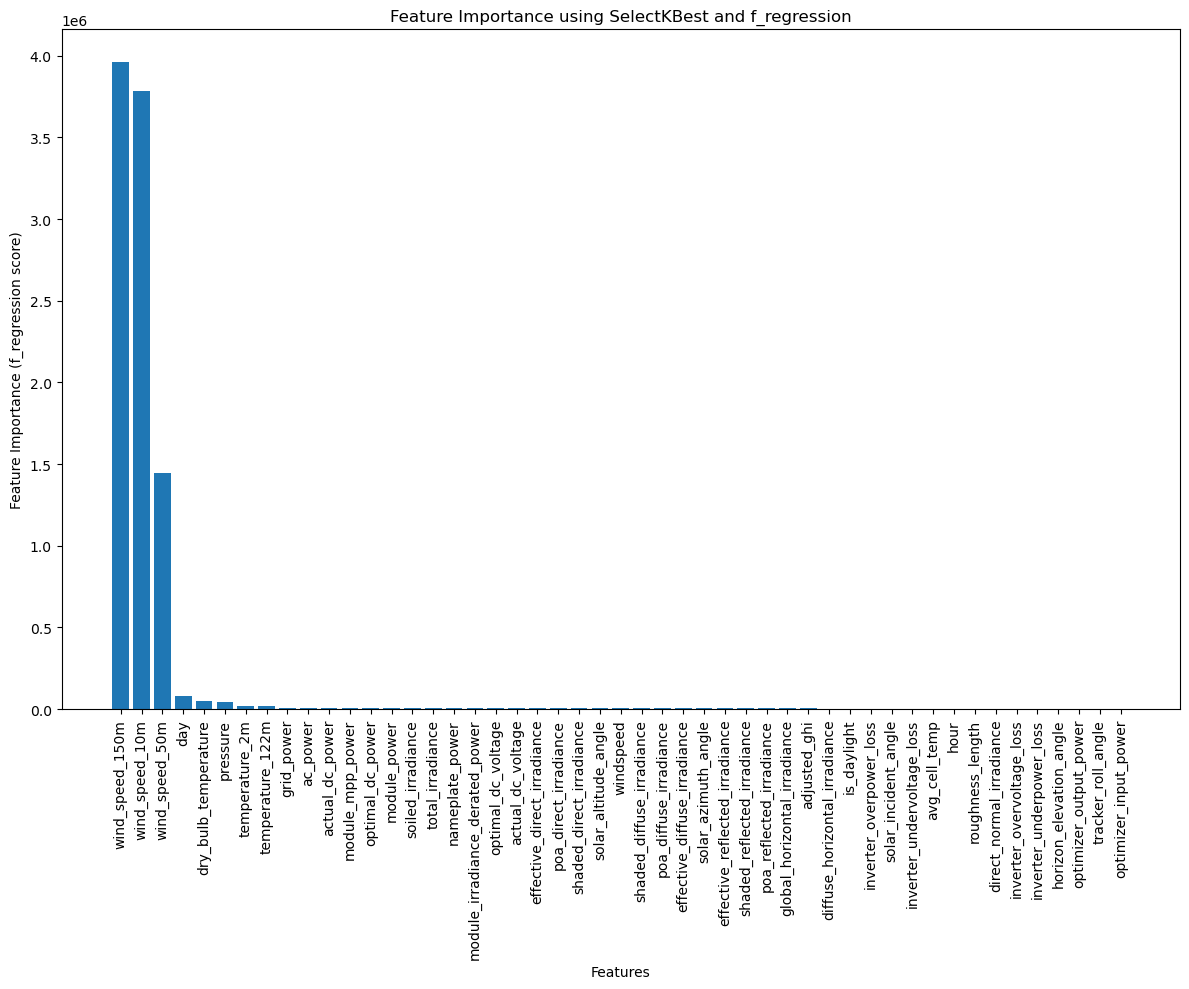

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Apply feature selection using SelectKBest and f_regression
fs = SelectKBest(score_func=f_regression, k=len(input_features))
X_selected = fs.fit_transform(X_train, y_train)

selected_feature_names = X_train.columns[fs.get_support()]  # Get the names of selected features
feature_importance_scores = fs.scores_[fs.get_support()]  # Get the importance scores of selected features

# Sort the selected feature names based on importance scores
sorted_indices = np.argsort(feature_importance_scores)[::-1]
selected_feature_names_sorted = selected_feature_names[sorted_indices]
sorted_importances = feature_importance_scores[sorted_indices]

# Print the selected feature names and their importance scores
for feature, score in zip(selected_feature_names_sorted, sorted_importances):
    print(f"{feature}, {score}")

        
plt.figure(figsize=(12, 10))
plt.bar(selected_feature_names_sorted, sorted_importances)
plt.xlabel('Features')
plt.ylabel('Feature Importance (f_regression score)')
plt.title('Feature Importance using SelectKBest and f_regression')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [47]:
# Actual features selection and scaling for the model

from sklearn.preprocessing import StandardScaler

# All features
# input_features = ['is_daylight', 'hour', 'day'] + solar_features + wind_features

# Select only the relevant features for input
# Top 20
input_features = ['wind_speed_150m','wind_speed_10m','wind_speed_50m','day','dry_bulb_temperature','pressure','temperature_122m','temperature_2m','grid_power','ac_power','actual_dc_power','module_mpp_power','optimal_dc_power','module_power','optimal_dc_voltage','soiled_irradiance','total_irradiance','nameplate_power','module_irradiance_derated_power','actual_dc_voltage']

# Top 10
# input_features = ['wind_speed_150m','wind_speed_10m','pressure','day','wind_speed_50m','dry_bulb_temperature','temperature_2m','temperature_122m','solar_altitude_angle','effective_direct_irradiance']
# input_features.sort()

# Other 
# input_features = ['day', 'hour','is_daylight','windspeed','solar_incident_angle']
target_feature = 'power_output'


# Prepare input (X) and target (y)
X = data[input_features]
y = data[target_feature]

# Resample data to hourly frequency
X_resampled = X.resample('H').mean()
y_resampled = y.resample('H').mean()

# Resample data to hourly frequency
# X_resampled = X.resample('10T').mean()
# y_resampled = y.resample('10T').mean()

# Prepare input (X) and target (y)
X = X_resampled
y = y_resampled

# Split data into training, validation, and prediction sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_pred, y_val, y_pred = train_test_split(X_temp, y_temp, test_size=0.33, shuffle=False)

# Normalize the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape y_train
y_test_scaled = scaler_y.fit_transform(y_val.values.reshape(-1, 1))  


In [48]:
import tensorflow as tf

time_steps = 240
num_features = X_train_scaled.shape[1]

X_train_reshaped = []
y_train_reshaped = []

for i in range(len(X_train_scaled) - time_steps + 1):
    X_train_reshaped.append(X_train_scaled[i:i+time_steps])
    y_train_reshaped.append(y_train_scaled[i+time_steps-1])  # Include the target for the next hour

X_train_reshaped = tf.convert_to_tensor(np.array(X_train_reshaped), dtype=tf.float32)
y_train_reshaped = tf.convert_to_tensor(np.array(y_train_reshaped), dtype=tf.float32)

X_test_reshaped = []
y_test_reshaped = []

for i in range(len(X_test_scaled) - time_steps + 1):
    X_test_reshaped.append(X_test_scaled[i:i+time_steps])
    y_test_reshaped.append(y_test_scaled[i+time_steps-1])  # Include the target for the next hour

X_test_reshaped = tf.convert_to_tensor(np.array(X_test_reshaped), dtype=tf.float32)
y_test_reshaped = tf.convert_to_tensor(np.array(y_test_reshaped), dtype=tf.float32)


In [65]:
input_features

['wind_speed_150m',
 'wind_speed_10m',
 'wind_speed_50m',
 'day',
 'dry_bulb_temperature',
 'pressure',
 'temperature_122m',
 'temperature_2m',
 'grid_power',
 'ac_power',
 'actual_dc_power',
 'module_mpp_power',
 'optimal_dc_power',
 'module_power',
 'optimal_dc_voltage',
 'soiled_irradiance',
 'total_irradiance',
 'nameplate_power',
 'module_irradiance_derated_power',
 'actual_dc_voltage']

In [71]:
# CLear workingDir
import shutil
shutil.rmtree("/kaggle/working/*")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/*'

In [78]:
from keras.layers import Input
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam
from keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, Huber
from keras.metrics import CosineSimilarity


model = Sequential([
    Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    LSTM(units=64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(y_train_reshaped.shape[1], activation='linear')
])

# model.compile(optimizer='adam', loss='mean_absolute_error')
optimizer = SGD (learning_rate=0.001)
loss_function = [Huber(),MeanAbsoluteError()]
metrics = [Huber(), CosineSimilarity(), MeanAbsoluteError(), MeanSquaredError(), MeanAbsolutePercentageError()]

model.compile(optimizer=optimizer, loss=loss_function, 
              metrics=metrics)
epochs=5
batch_size=24
# model.compile(optimizer=optimizer, loss=["huber_loss", "mean_absolute_error"], 
#               metrics=[tf.keras.metrics.CosineSimilarity(axis=1),"mae"])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

# Checkpoint callback
path_checkpoint = "model_checkpoint.h5"

checkpoint = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

model.summary()

history = model.fit(X_train_reshaped, y_train_reshaped, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test_reshaped, y_test_reshaped), callbacks=[early_stopping, checkpoint])

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 64)                21760     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
246/246 [==============================] - ETA: 0s - loss: 0.3533 - huber_loss: 0.3531 - cosine_similarity: 0.4549 - mean_absolute_error: 0.6854 - mean_squared_error: 0.9032 - mean_absolute_percentage_error: 146.3037
Epoch 1: val_loss improved from inf to 0.41569, saving model to model_checkpoint.h5
246/246 [==============================] - 29s 112ms/step - loss: 0.3533 - huber_loss: 0.3531 - cosine_similarity: 0.4549 - mean_absol

In [69]:
sample_indices = np.random.choice(len(y_pred_scaled), size=10, replace=False)

sample_actual_values = y_test_scaled[sample_indices]
sample_predicted_values = y_pred_scaled[sample_indices]

for i in range(len(sample_indices)):
    print(f"Sample {i+1} - Actual: {sample_actual_values[i]}, Predicted: {sample_predicted_values[i]}")

Sample 1 - Actual: [-0.52653995], Predicted: [-0.53368056]
Sample 2 - Actual: [1.56532419], Predicted: [-0.8880768]
Sample 3 - Actual: [-0.54908188], Predicted: [0.1840169]
Sample 4 - Actual: [-0.36425882], Predicted: [-0.22140801]
Sample 5 - Actual: [-0.94698424], Predicted: [-0.68751776]
Sample 6 - Actual: [1.88452944], Predicted: [-0.39511552]
Sample 7 - Actual: [-0.56939958], Predicted: [0.0229301]
Sample 8 - Actual: [2.06979282], Predicted: [-0.14179833]
Sample 9 - Actual: [-0.90983798], Predicted: [-0.8545768]
Sample 10 - Actual: [-0.76440409], Predicted: [0.04435759]


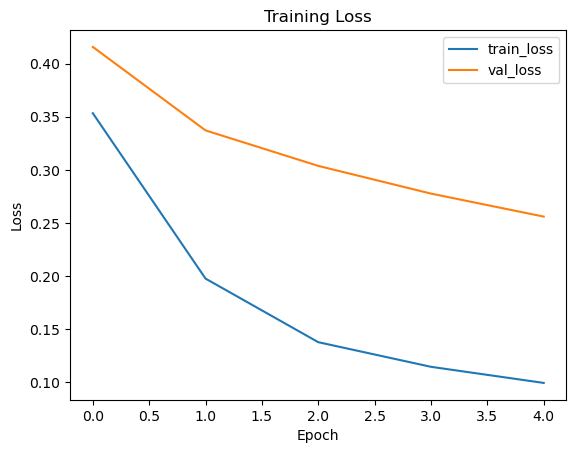

48/48 [==============================] - 2s 40ms/step


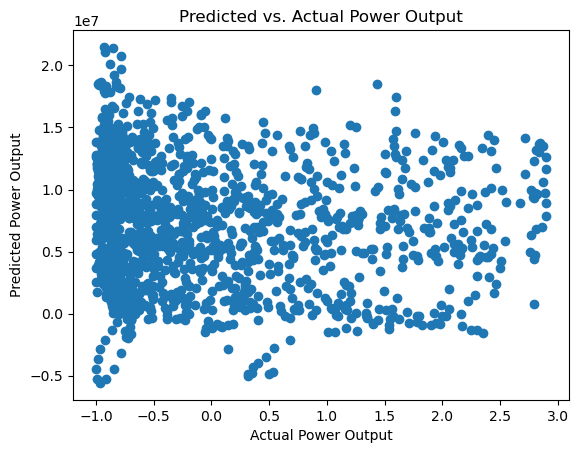

In [79]:

# Visualize training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

## Make predictions on the testing set
y_pred_scaled = model.predict(X_test_reshaped)

y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Flatten y_test_scaled and y_pred arrays
y_test_flat = y_test_scaled.flatten()
y_pred_flat = y_pred.flatten()

# Ensure both arrays have the same length
min_length = min(len(y_test_flat), len(y_pred_flat))
y_test_flat = y_test_flat[:min_length]
y_pred_flat = y_pred_flat[:min_length]

# Visualize predicted vs. actual power_output
plt.scatter(y_test_flat, y_pred_flat)
# plt.scatter(y_train_scaled, train_pred, label= "Training prediction")
plt.xlabel("Actual Power Output")
plt.ylabel("Predicted Power Output")
plt.title("Predicted vs. Actual Power Output")
plt.show()
